In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.metrics import accuracy_score

In [12]:
ddf = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/dataset_for_analysis.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/L1/Notebooks/dataset/dataset_for_analysis.pkl'

In [3]:
#ddf.drop(['label_m1','label_m2','label_m3','label_m4',
#'label_w1','label_w2','label_w3','label_w4'],axis= 1,inplace = True)
ddf

,spent_less,cloth_lingerie_purch_diff,cloth_sports_purch_diff,cloth_etc_purch_diff,cloth_business_purch_diff,hobby_media_purch_diff,hobby_pet_purch_diff,hobby_outdoor_purch_diff,hobby_sports_purch_diff,hobby_health_purch_diff,...,CLOTH_WOMEN_PERDAY_VISITING,HOBBY_PET_PERDAY_VISITING,HOBBY_GOLF_PERDAY_VISITING,HOBBY_MEDIA_PERDAY_VISITING,HOBBY_CHILD_PERDAY_VISITING,HOBBY_HEALTH_PERDAY_VISITING,HOBBY_OUTDOOR_PERDAY_VISITING,HOBBY_INSTEX_PERDAY_VISITING,MEMBERSHIP_CAT_2,MEMBERSHIP_CAT_3
0,1,0.000000,0.0,-0.000051,-0.000102,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,0.000,0,0
1,0,0.001979,0.0,-0.000142,0.000000,0.0,-0.00036,0.000000,0.0,0.0,...,0.0,-0.011,-0.0549,0.0,0.0,0.0,0.000,0.000,0,0
2,1,0.000000,0.0,0.000000,0.000253,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,-0.0110,0.0,0.0,0.0,0.000,0.000,0,0
3,0,0.000350,0.0,0.000037,-0.000011,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,0.0110,0.0,0.0,0.0,0.000,0.000,0,0
4,0,0.000114,0.0,-0.000813,-0.000187,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,-0.0110,0.0,0.0,0.0,0.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16290,0,0.000011,0.0,-0.000010,0.000000,0.0,0.00000,0.000971,0.0,0.0,...,0.0,0.000,0.0000,0.0,0.0,0.0,0.033,0.000,0,0
16291,1,0.000000,0.0,0.000000,-0.000083,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,0.000,0,1
16292,1,-0.000282,0.0,-0.000065,0.000144,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,-0.011,0,0
16293,1,-0.000024,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000,0.0000,0.0,0.0,0.0,0.000,0.000,0,0


In [4]:
# label, feature 분리
y_labels = ddf['spent_less']
X_features= ddf.drop('spent_less', axis=1)

In [5]:
# 비율확인
print(ddf['spent_less'].value_counts())
unsatisfied_cnt = ddf[ddf['spent_less'] == 1].spent_less.count()
total_cnt = ddf.spent_less.count()
print('spent_less 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

1    8818
0    7477
Name: spent_less, dtype: int64
spent_less 비율은 0.54


In [6]:
# train , test  8:2 로 나눔
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

In [7]:
# get_clf_eval 함수 
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC AUC는 pred 대신 pred_proba
    roc_score=roc_auc_score(y_test,pred_proba) # pred_proba

    print('오차행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f},\
    f1 score:{3:.4f}, ROC AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_score))

In [9]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=100)

params = {'num_leaves': [32,64,128],
          'min_child_samples' : [64,128,256],
          'max_depth':[4,8,16,32,64]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train)
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

GridSearchCV 최적 파라미터: {'max_depth': 16, 'min_child_samples': 128, 'num_leaves': 64}


In [10]:
#최적 파라미터 max_depth:16, min_child_samples: 128 num_leaves : 64 튜닝 후
lgb_wrapper = LGBMClassifier(n_estimators=100,random_state=156,max_depth=16,min_child_samples=128,num_leaves=64)
evals = [(X_test, y_test)]

# 조기중단 수행
lgb_wrapper.fit(X_train,y_train, early_stopping_rounds=10,eval_set=evals, \
                eval_metric='logloss',verbose=True)
w_preds = lgb_wrapper.predict(X_test)
w_preds_proba = lgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_preds_proba)

[1]	valid_0's binary_logloss: 0.642879
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.604585
[3]	valid_0's binary_logloss: 0.572151
[4]	valid_0's binary_logloss: 0.545645
[5]	valid_0's binary_logloss: 0.522572
[6]	valid_0's binary_logloss: 0.503264
[7]	valid_0's binary_logloss: 0.486252
[8]	valid_0's binary_logloss: 0.471283
[9]	valid_0's binary_logloss: 0.458795
[10]	valid_0's binary_logloss: 0.44773
[11]	valid_0's binary_logloss: 0.438276
[12]	valid_0's binary_logloss: 0.429876
[13]	valid_0's binary_logloss: 0.422434
[14]	valid_0's binary_logloss: 0.41596
[15]	valid_0's binary_logloss: 0.410169
[16]	valid_0's binary_logloss: 0.405196
[17]	valid_0's binary_logloss: 0.400508
[18]	valid_0's binary_logloss: 0.396363
[19]	valid_0's binary_logloss: 0.392579
[20]	valid_0's binary_logloss: 0.389033
[21]	valid_0's binary_logloss: 0.385388
[22]	valid_0's binary_logloss: 0.382791
[23]	valid_0's binary_logloss: 0.380618
[24]	valid_0's binary_logloss:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

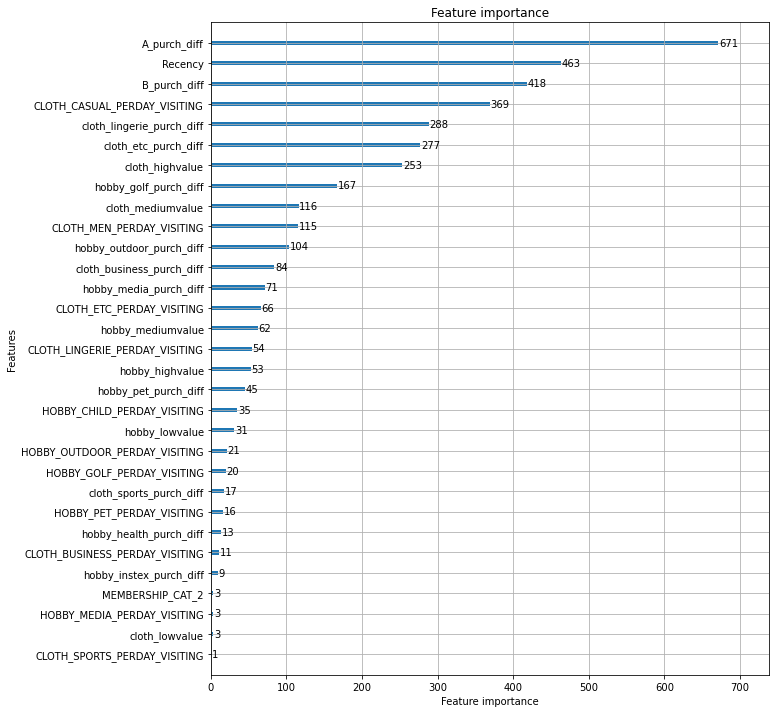

In [11]:
#Feature_importance 출력
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize = (10,12))
plot_importance(lgb_wrapper, ax=ax)